# Circle packing

The aim is to arrange $n$ circles in $\mathbb{R}^2$ with given radii $r_i$ for $i=1,\ldots,n$, so that they do not overlap and are contained in the smallest possible square \[Spe13]. The optimization problem can be formulated as

$$
\begin{align}
\text{minimize} & \displaystyle \max_{i=1,\ldots,n}\bigl(\lVert c_i\rVert_\infty + r_i\bigr)\\
\text{subject to} & \, \lVert c_i - c_j\rVert_2 \ge r_i + r_j,\qquad 1 \le i < j \le n,
\end{align}
$$

where the variables are the centers of the circles $c\_i \in \mathbb{R}^2$, $i=1,\ldots,n$, and $r_i$, $i=1,\ldots,n$, are given data. 

If $\ell$ is the value of the objective function, the circles are contained in the square $[-\ell,\ell]\times[-\ell,\ell]$.

## Model definition

In the following code, we solve the circle packing problem with CVXPY using DCCP.

In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

from dccp import is_dccp

rng = np.random.default_rng(1)

# number of circles
n = 10

# radii of circles
r = rng.uniform(1.0, 3.0, n)

# coordinates of circle centers
c = cp.Variable((n, 2))

# constraint eq.: (2)
constr = []
for i in range(n - 1):
    for j in range(i + 1, n):
        constr += [cp.norm(c[i, :] - c[j, :]) >= r[i] + r[j]]

# objective: minimize the maximum distance from the origin to the circle center + radius
prob = cp.Problem(cp.Minimize(cp.max(cp.max(cp.abs(c), axis=1) + r)), constr)

### As we can see, the problem is not DCP compliant:

In [2]:
print("The problem is DCP compliant:", prob.is_dcp())

The problem is DCP compliant: False


### But we can solve it with DCCP!

In [3]:
print("The problem is DCCP compliant:", is_dccp(prob))
result = prob.solve(method="dccp", solver="ECOS", max_iter=50, max_slack=1e-4, k_ccp=3)
assert prob.status == cp.OPTIMAL, "DCCP failed to find optimal solution"
assert result is not None, "DCCP failed to find a solution"
print("DCCP solver result:", result)

The problem is DCCP compliant: True
DCCP solver result: 6.889403707392226


## Visual verification of the results

To verify the results we will plot each circle at its optimal position as found by the 
DCCP algorithm.

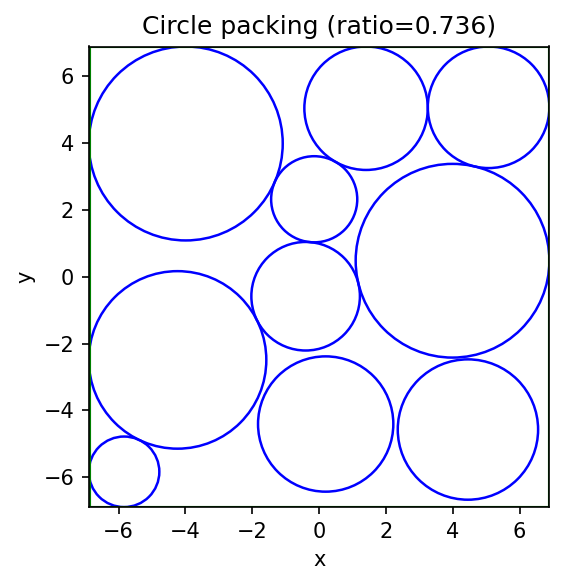

In [4]:
from matplotlib.patches import Circle, Rectangle

# the original 'c' variable
circle_centers = prob.variables()[0]

max_expr = cp.max(cp.max(cp.abs(circle_centers), axis=1) + r)

assert max_expr.value is not None, (
    "Optimization did not assign a value to the variable."
)

square_size = float(max_expr.value) * 2
pi = np.pi
ratio = pi * np.sum(np.square(r)) / (square_size**2)

# create plot to visualize the packing
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_aspect("equal", adjustable="box")
fig.set_dpi(150)

# draw circles
for i in range(n):
    x_val = circle_centers[i, 0].value
    y_val = circle_centers[i, 1].value
    if x_val is None or y_val is None:
        msg = f"Circle center value not assigned for index {i}."
        raise ValueError(msg)
    circle = Circle(
        (float(x_val), float(y_val)),  # (x, y) center
        r[i],  # radius
        fill=False,  # outline only
        ec="b",
        lw=1.2,  # edge color/width
    )
    ax.add_patch(circle)

# draw square border
border = Rectangle(
    (-square_size / 2, -square_size / 2),  # bottom-left
    square_size,
    square_size,  # width, height
    fill=False,
    ec="g",
    lw=1.5,
)
ax.add_patch(border)

# limits and cosmetics
ax.set_xlim(float(-square_size / 2), float(square_size / 2))
ax.set_ylim(float(-square_size / 2), float(square_size / 2))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Circle packing (ratio={ratio:.3f})")
fig.tight_layout()